In [1]:
!pip install -q timm #for pretrained models
!pip install -q albumentations==0.4.6 #for image augmentations
!pip -q install astropy # for working with .fits data

In [2]:
import astropy
from astropy.io import fits
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import model_selection

import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob
import sklearn
import math
import random

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#make sure device is "cuda"
print(device)

cuda


In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)

# Hyperparameters (Kindly change the path of the model's weight according to where you have stored)

In [4]:
image_size = 100
pretrained_model = "tf_efficientnet_b2_ns"
#path to best model weights of each fold
path0 = "../input/lens-finding/Fold 0 val_auc 0.9676701333804952.pth"
path1 = "../input/lens-finding/Fold 1 val_auc 0.9746340010001936.pth"
path2 = "../input/lens-finding/Fold 2 val_auc 0.9711369566427682.pth"
path3 = "../input/lens-finding/Fold 3 val_auc 0.9701803249679135.pth"
path4 = "../input/lens-finding/Fold 4 val_auc 0.9768519061775269.pth"

In [5]:
file = tarfile.open('../input/lens-find/lens_finding.tgz')
file.extractall("data/")

In [6]:
df = pd.read_csv("./data/SpaceBasedTraining/classifications.csv")
df.ID = df.ID.astype(str)

In [7]:
images_present = os.listdir("./data/SpaceBasedTraining/files")

In [8]:
all_images = []
for i in images_present:
    all_images.append(i.split('imageEUC_VIS-')[-1].split('.fits')[0])

In [9]:
#making sure only use the rows of the dataframe if corresponding image is available
df = df[df.ID.isin(all_images)].reset_index(drop = True)

In [10]:
img_pths = "./data/SpaceBasedTraining/files/imageEUC_VIS-"
df['path'] = [ f"{img_pths}{x}.fits" for x in df["ID"]]

In [11]:
from sklearn import model_selection
y = df.is_lens.values
kf = model_selection.StratifiedKFold(n_splits =10, random_state=42 , shuffle=True)

for f,(t,v) in enumerate(kf.split(X=df,y=y)):
    df.loc[v,'fold'] = f
    
test = df[df.fold == 0].reset_index(drop = True)

In [12]:
test_aug = A.Compose(
    [ 
     A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

In [13]:
meta_features = ["Einstein_area" , "numb_pix_lensed_image" , "flux_lensed_image_in_sigma"]

In [14]:
def feature_engg(meta_data):
    data = meta_data.copy()
    data.Einstein_area = data.Einstein_area/(data.Einstein_area.max())
    data.numb_pix_lensed_image = data.numb_pix_lensed_image/(data.numb_pix_lensed_image.max())
    data.flux_lensed_image_in_sigma = data.flux_lensed_image_in_sigma/(data.flux_lensed_image_in_sigma.max())

    return data

In [15]:
class Lens(Dataset):
    def __init__(self,df , augs):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img =  fits.open(self.df.path[idx])
        image =  img[0].data
        image = image/np.max(image)
        image = np.expand_dims(image , axis = 2)
        transformed = self.augs(image=image)
        image = transformed['image']
        
        meta = torch.tensor(self.df[meta_features].iloc[idx,:].values, dtype=torch.float)
    
        return image , meta

In [16]:
class Model(nn.Module):
    def __init__(self,pretrained = False):
        super().__init__()
        self.backbone = timm.create_model(pretrained_model, pretrained=pretrained, num_classes=0, drop_rate=0.0,global_pool='',in_chans=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin2 = nn.Linear(1408+3,1)
        self.do = nn.Dropout(p=0.4)
        self.lin1 = nn.Linear(3,3)
    
    def forward(self,image , feat):
        image = self.backbone(image)     
        image = self.pool(image)
        image = image.view(image.shape[0], -1)
        
        image = self.do(image)
        feat = self.lin1(feat)
        x = torch.cat([image , feat ], dim = 1)#concat embeddings
        x = self.lin2(x)
        return x

In [17]:
def inference_func(test_loader , path,m):
    m = m.to(device)
    m.load_state_dict(torch.load(path))
    m.eval()
    bar = tqdm(test_loader)

    PREDS = []
    
    with torch.no_grad():
        for batch_idx, (images,feat) in enumerate(bar):
            img = images.to(device)
            feat = feat.to(device)
            output = m(img,feat)
            output = output.sigmoid()
            PREDS += [output.detach().cpu()]
        PREDS = torch.cat(PREDS).cpu().numpy()  
    return PREDS

In [18]:
test_fe = feature_engg(test)
test_data= Lens(test_fe.reset_index(drop=True),test_aug)
tl = DataLoader(test_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last = False)

In [19]:
#getting the predictions from each the best model for each fold
y0 = inference_func(tl ,path0 , Model())
y1 = inference_func(tl ,path1 , Model())
y2 = inference_func(tl ,path2 , Model())
y3 = inference_func(tl ,path3 , Model())
y4 = inference_func(tl ,path4 , Model())
# averaginf all the predictions from each fold
y = (y0 + y1 + y2 + y3 + y4)/5.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

# Results on Test

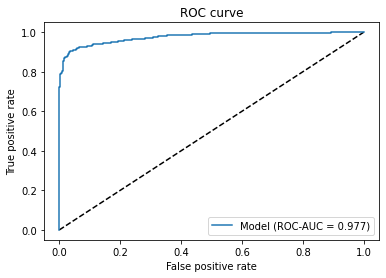

In [20]:
y_test = test.is_lens.values # ground_truth
fpr, tpr, _ = roc_curve(y_test, y)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
import shutil
shutil.rmtree("data/")